## Welcome to part 4 of the workshop.
##### Here, we will explore more specific packages used for:
- mixed linear models
- optimization
- multivariate statistics
- deep learning
- differential equations

## GLM.jl

https://juliastats.org/GLM.jl/stable/

In [1]:
using Pkg; Pkg.add(["GLM", "DataFrames", "MixedModels"])
using GLM, DataFrames, MixedModels

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [2]:
# Data: reaction times for subjects after days of sleep deprivation

data = DataFrame(MixedModels.dataset(:sleepstudy));
describe(data)

3×7 DataFrame
 Row │ variable  mean     min      median   max      nmissing  eltype   
     │ Symbol    Union…   Any      Union…   Any      Int64     DataType 
─────┼──────────────────────────────────────────────────────────────────
   1 │ subj               S308              S372            0  String
   2 │ days      4.5      0        4.5      9               0  Int8
   3 │ reaction  298.508  194.332  288.651  466.353         0  Float64

In [3]:
# We will first fit a simple linear model on this data.
# We will regress the reaction time against the number of days of sleep deprivation (with an intercept)

fm = @formula(reaction ~ 1 + days)
println(fm)
model = fit(LinearModel, fm, data)

reaction ~ 1 + days


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

reaction ~ 1 + days

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  251.405      6.61015  38.03    <1e-86  238.361     264.449
days          10.4673     1.2382    8.45    <1e-14    8.02386    12.9107
────────────────────────────────────────────────────────────────────────

In [4]:
# The coefficients are obtained with 'coef' and their standard error with 'stderror'

println(coef(model))
println(stderror(model))

[251.405104848485, 10.467285959595939]
[6.610154044287575, 1.238195298049819]


In [9]:
# To obtain everything else like p-values, use 'coeftable(model).cols'

display(coeftable(model).cols)
println(coeftable(model))

6-element Vector{Any}:
 [251.405104848485, 10.467285959595939]
 [6.610154044287575, 1.238195298049819]
 [38.0331688435834, 8.45366314674439]
 [2.1568882818123116e-87, 9.894096322215885e-15]
 [238.3607531871242, 8.023855022133414]
 [264.4494565098458, 12.910716897058464]

────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  251.405      6.61015  38.03    <1e-86  238.361     264.449
days          10.4673     1.2382    8.45    <1e-14    8.02386    12.9107
────────────────────────────────────────────────────────────────────────


In [10]:
# We can obtain various metrics of fitness:

println(r2(model))
println(adjr2(model))
println(aic(model))
println(bic(model))
println(loglikelihood(model))

0.28647139510771
0.2824628074397758
1906.2930563563636
1915.8719269090343
-950.1465281781818


In [11]:
# To obtain the predictions of the model to some independents, use 'predict'

predict(model, DataFrame(:days => [1, 2, 3]))

3-element Vector{Union{Missing, Float64}}:
 261.8723908080809
 272.33967676767685
 282.80696272727283

## MixedModels.jl

https://juliastats.org/MixedModels.jl/dev/

In [15]:
# If we wanted to incorporate the random effect of subjects, we need to use mixed models.
# This is where MixedModels.jl comes in. The syntax is the same as before.
# The only difference is that random effects have a '|' in front of them.

fm = @formula(reaction ~ 1 + days + (1|subj))
println(fm)
model = fit(MixedModel, fm, data)
println(model)

reaction ~ 1 + days + :(1 | subj)
Linear mixed model fit by maximum likelihood
 reaction ~ 1 + days + (1 | subj)
   logLik   -2 logLik     AIC       AICc        BIC    
  -897.0393  1794.0786  1802.0786  1802.3072  1814.8505

Variance components:
            Column    Variance Std.Dev.
subj     (Intercept)  1296.8707 36.0121
Residual               954.5278 30.8954
 Number of obs: 180; levels of grouping factors: 18

  Fixed-effects parameters:
──────────────────────────────────────────────────
                Coef.  Std. Error      z  Pr(>|z|)
──────────────────────────────────────────────────
(Intercept)  251.405     9.50619   26.45    <1e-99
days          10.4673    0.801735  13.06    <1e-38
──────────────────────────────────────────────────


In [16]:
# To get the fixed and random effects, use either 'coef' or 'fixef' and 'ranef'

println(fixef(model))
println(ranef(model)[1][:])

[251.4051048484842, 10.467285959595921]
[40.63509807828764, -77.5658778312192, -62.878606103534764, 4.390385477931814, 10.178962393819326, 8.191280525877747, 16.44036798974279, -2.9860604843171785, -45.11712362809099, 71.9196596399184, -21.119011954668974, 14.059942956627465, -7.83357205674435, 36.245866037930014, 7.010741050397668, -6.339518002903397, -3.2822688418576034, 18.049734752817816]


In [17]:
# To obtain the variance of the fixed effects, an unfortunately long notation is used
# (subj and Intercept here are dependent on your formula and data)

VarCorr(model).σρ.subj.σ.var"(Intercept)"

36.01209068826188

## Optim.jl

https://julianlsolvers.github.io/Optim.jl/stable/

Optim.jl let's us minimize a broad range of functions.

In [19]:
Pkg.add(["Optim", "Plots"])
using Optim, Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


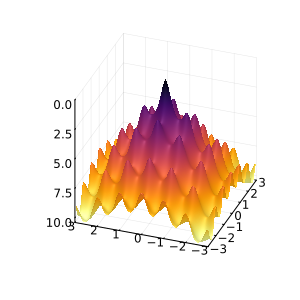

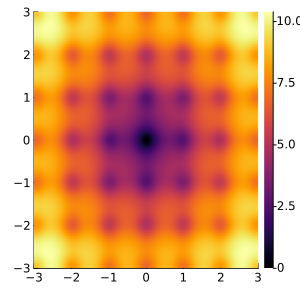

 * Status: success

 * Candidate solution
    Final objective value:     3.574452e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    34
    f(x) calls:    67


In [32]:
# The main syntax is: define an objective function that takes in a vector of parameters x
# and spits out a number. Use the 'optimize' function with an initial point and potential bounds,
# and if possible, gradients, and optimize away!

f(x) = -20.0 * exp(-0.2*sqrt(0.5 * (x[1]^2 + x[2]^2))) - exp(0.5*(cos(2π*x[1]) + cos(2π*x[2]))) + ℯ + 20
x = collect(-3:0.01:3); y = collect(-3:0.01:3); mat = reduce(hcat, [[f([x[i], y[j]]) for i in eachindex(x)] for j in eachindex(y)]);

display(plot(x, y, mat, st=:surface, camera=(20,30), xflip=true, zflip=true, cmap=cgrad(:inferno, rev=true), size=(300, 300), colorbar=false))
display(heatmap(x, y, mat, size=(300, 300)))

x0 = [1.0, -1.0]
res = optimize(f, x0)

# Check out https://julianlsolvers.github.io/Optim.jl/stable/user/config/
# for all possible configurable options such as tolerance, function calls and time limit

[0.9684765599814207, -0.968474331445709]
3.574451877564904


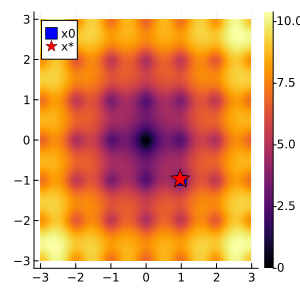

In [24]:
# 'Optim.minimizer' and 'Optim.minimum' give the results

xstar = Optim.minimizer(res)
println(xstar)
println(Optim.minimum(res))

scatter!([x0[1]], [x0[2]], c=:blue, markershape=:square, markersize=5, label="x0")
scatter!([xstar[1]], [xstar[2]], c=:red, markershape=:star5, markersize=10, label="x*")

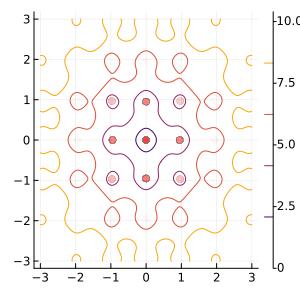

In [25]:
# As you can see, this initial point leads us to converge to a local minimum.
# Unfortunately, there is no way to guarantee global convergence if our function is not convex.
# One good remedy is to do multiple starting points, and select the minimum from all starts.

xstars = zeros(1000, 2)
for i in 1:1000
    x0 = [randn(), randn()]
    res = optimize(f, x0)
    xstars[i, :] = Optim.minimizer(res)
end

plot(x, y, mat, levels=4, size=(300, 300))
scatter!(xstars[:, 1], xstars[:, 2], label=nothing, alpha=0.01, c=:red)

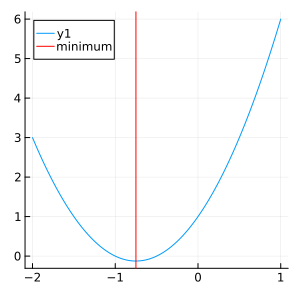

In [26]:
# If your function is univariate (over one variable), you can converge using bounds without needing a starting point

f_univariate(x) = 2x^2+3x+1
res = optimize(f_univariate, -2.0, 1.0)
x = -2:0.01:1; y = f_univariate.(x);
plot(x, y, size=(300, 300))
vline!([Optim.minimizer(res)], c=:red, label="minimum")

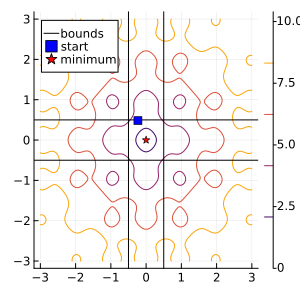

In [34]:
# If you have more than one variable, and you wish to impose bounds, you must specify a gradient.
# If you can't compute gradients explicitely, you can use automatic differentiating to do it for you.
# Below is an example

lb = [-0.5, -0.5]
ub = [0.5, 0.5]
x0 = [rand()-0.5, rand()-0.5]
res = optimize(f, lb, ub, x0, Fminbox(); autodiff=:forward)
xstar = Optim.minimizer(res)

x = collect(-3:0.01:3); y = collect(-3:0.01:3); mat = reduce(hcat, [[f([x[i], y[j]]) for i in eachindex(x)] for j in eachindex(y)]);
plot(x, y, mat, levels=4, size=(300, 300))
vline!([lb[1], ub[1]], label=nothing, c=:black)
hline!([lb[2], ub[2]], label="bounds", c=:black)
scatter!([x0[1]], [x0[2]], markershape=:square, label="start", c=:blue)
scatter!([xstar[1]], [xstar[2]], markershape=:star5, label="minimum", c=:red)

## MultivariateStats.jl

https://juliastats.org/MultivariateStats.jl/dev/

In [37]:
Pkg.add(["MultivariateStats", "RDatasets"])
using MultivariateStats, RDatasets

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [40]:
# We will use a dataset that measures flowers in 4 ways (4 variables) and labels them into three categories.
# We will use multiple component analysis tools to reduce the dimensionality from 4 to 2

data = RDatasets.dataset("datasets", "iris")
X = Matrix(data[:, 1:4])'
y = Vector(data[:, 5])

function iris_plot(Xp, y, sp, title)
    for s in unique(y)
        points = Xp[:, y .== s]
        scatter!(points[1, :], points[2, :], label=nothing, sp=sp, title=title)
    end
end

iris_plot (generic function with 1 method)

In [43]:
# A whole set of analyses is implemented, here shown are:
# - PCA, you can set the output dimension with 'maxoutdim' (PPCA is similar)
# - LDA (Subspace LDA is similar)
# - ICA
# - Factor Analysis
# - MDS

pca = fit(PCA, X; maxoutdim=2)
lda = fit(MulticlassLDA, X, y, outdim=2)
ica = fit(ICA, X, 2; tol=1e-1)
fa = fit(FactorAnalysis, X; maxoutdim=2)
mds = fit(MDS, X; maxoutdim=2, distances=false);

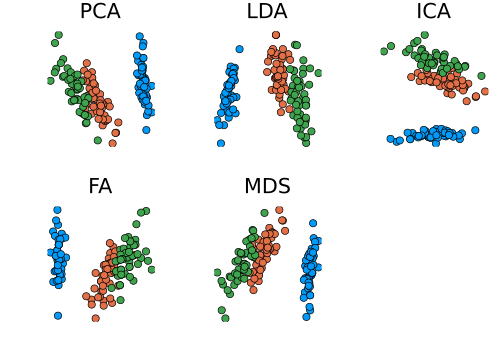

In [45]:
# The results of each are shown below (they are all very similar)

plot(layout=(2, 3), size=(500, 350), showaxis=false, grid=false)

Xp = predict(pca, X);
iris_plot(Xp, y, 1, "PCA")

Xp = predict(lda, X);
iris_plot(Xp, y, 2, "LDA")

Xp = predict(ica, X);
iris_plot(Xp, y, 3, "ICA")

Xp = predict(fa, X);
iris_plot(Xp, y, 4, "FA")

Xp = predict(mds);
iris_plot(Xp, y, 5, "MDS")

plot!()

## Flux.jl

https://fluxml.ai/Flux.jl/stable/

This is the most prominent deep learning package in Julia with great CUDA support.

This simple tutorial will train a small network to solve the XOR task.

In [51]:
Pkg.add(["Flux", "ProgressMeter"])
using Flux, ProgressMeter, Plots, Statistics

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [57]:
# Below we generate the input and target data.

input = rand(Float32, 2, 1000)
truth = [xor(col[1]>0.5, col[2]>0.5) for col in eachcol(input)]
target = Flux.onehotbatch(truth, [true, false])
loader = Flux.DataLoader((input, target), batchsize=64, shuffle=true)

16-element DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=64)
  with first element:
  (2×64 Matrix{Float32}, 2×64 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [58]:
# The model is very simply, it has 3 hidden units with tanh activation, a batchnorm and
# a softmax at the end.

model = Chain(
    Dense(2 => 3, tanh),   # activation function inside layer
    BatchNorm(3),
    Dense(3 => 2),
    softmax)

Chain(
  Dense(2 => 3, tanh),                  # 9 parameters
  BatchNorm(3),                         # 6 parameters, plus 6
  Dense(3 => 2),                        # 8 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 23 parameters,
          # plus 2 non-trainable, 6 parameters, summarysize 604 bytes.

In [59]:
# These should be random outputs since the network is initialized randomly

initial_predictions = model(input)

2×1000 Matrix{Float32}:
 0.569634  0.621961  0.639759  0.61847  …  0.670517  0.531804  0.618951
 0.430366  0.378039  0.360241  0.38153     0.329483  0.468196  0.381049

In [60]:
# Here is where a lot of hyperparameters go, we'll keep it simple and use Adam with a momentum parameter of 0.01

optim = Flux.setup(Flux.Adam(0.01), model);

In [61]:
# This is the main training loop (it takes a few seconds to get started)

losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m # This is the forward pass
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1]) # This is the backprop step
        push!(losses, loss)  # logging, outside gradient context
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


In [62]:
# These should be close to perfect

final_predictions = model(input)

2×1000 Matrix{Float32}:
 2.39506f-8  0.00133836  0.327201  …  0.518888  0.235727  0.000114967
 1.0         0.998662    0.672799     0.481112  0.764273  0.999885

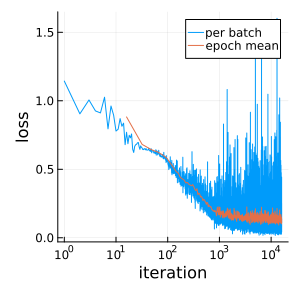

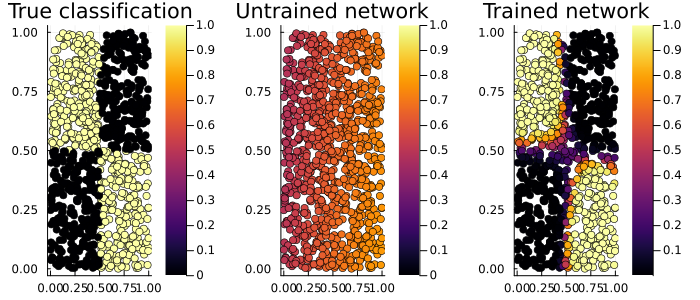

In [63]:
# We plot the results

plot(losses; xaxis=(:log10, "iteration"), yaxis="loss", label="per batch", size=(300, 300))
n_batches = length(loader); n_epocs = length(losses);
plot!(n_batches:n_batches:n_epocs, mean.(Iterators.partition(losses, n_batches)), label="epoch mean")
display(plot!())

plot(layout=(1, 3), size=(700, 300))
p_true = scatter!(input[1,:], input[2,:], sp=1, zcolor=truth, title="True classification", legend=false)
p_raw =  scatter!(input[1,:], input[2,:], sp=2, zcolor=initial_predictions[1,:], title="Untrained network", label="", clims=(0,1))
p_done = scatter!(input[1,:], input[2,:], sp=3, zcolor=final_predictions[1,:], title="Trained network", legend=false)

## DifferentialEquations.jl

https://docs.sciml.ai/DiffEqDocs/stable/

This is perhaps the most successful and well-known package in Julia. It is the gold-standard if you're numerically solving any type of differential equation. 

It works by setting up a differential equation problem, and then using `solve` to solve it.

In [64]:
Pkg.add(["DifferentialEquations"])
using DifferentialEquations

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [65]:
# To set up the problem, we need 3 things:
# - the dynamics equation
# - the initial conditions
# - the timepoints/time segment to evaluate at
# In this first very simple equation, we have du/dt = 1.01u
# The dynamics function represents the right hand side of this equation and takes in three arguments:
# - u the variable of interest (which may be a vector)
# - p the parameters of the model
# - t the timepoint
# We then set the initial conditions (here to 0.5) and the time range to between 0 and 1

f(u, p, t) = 1.01 * u
u0 = 1 / 2
tspan = (0.0, 1.0)
prob = ODEProblem(f, u0, tspan)

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

In [66]:
# To solve the problem, we simply pass 'prob' to 'solve'
# There are many arguments solve can take such as which algorithm to use, or which tolerance.

sol = solve(prob)

retcode: Success
Interpolation: 3rd order Hermite
t: 5-element Vector{Float64}:
 0.0
 0.09964258706516003
 0.3457024247583422
 0.6776921908052249
 1.0
u: 5-element Vector{Float64}:
 0.5
 0.552938681151017
 0.7089376245893466
 0.9913594502399236
 1.3728004409033037

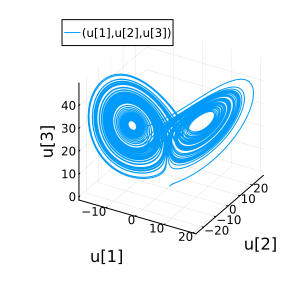

In [72]:
# In the multivariate case, the dynamics function 'f' would be slightly different.
# Below is the Lorenz attractor (3-dimensional). In this case, we have an extra argument: du
# du is the vector of gradients that we will fill in. We do this in place for memory reasons
# This means the function does not return anything (hence the '!')

function lorenz!(du, u, p, t)
    du[1] = 10.0 * (u[2] - u[1])
    du[2] = u[1] * (28.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - (8 / 3) * u[3]
end
prob = ODEProblem(lorenz!, [1.0; 0.0; 0.0], (0.0, 100.0))
sol = solve(prob, Tsit5()) # Tsit5 is a 5th (?!) order solver.
plot(sol, idxs = (1, 2, 3), size=(300, 300))

In [76]:
# Example using Hodgkin-Huxley model
# The example below implements the 4-dimensional HH model (https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model)

# Potassium ion-channel rate functions
alpha_n(v) = (0.02 * (v - 25.0)) / (1.0 - exp((-1.0 * (v - 25.0)) / 9.0));
beta_n(v) = (-0.002 * (v - 25.0)) / (1.0 - exp((v - 25.0) / 9.0));

# Sodium ion-channel rate functions
alpha_m(v) = (0.182 * (v + 35.0)) / (1.0 - exp((-1.0 * (v + 35.0)) / 9.0));
beta_m(v) = (-0.124 * (v + 35.0)) / (1.0 - exp((v + 35.0) / 9.0));

alpha_h(v) = 0.25 * exp((-1.0 * (v + 90.0)) / 12.0);
beta_h(v) = (0.25 * exp((v + 62.0) / 6.0)) / exp((v + 90.0) / 12.0);

function HH!(du, u, p, t)
    gK, gNa, gL, EK, ENa, EL, C, I = p
    v, n, m, h = u
    # membrane potential
    du[1] = (-(gK * (n^4.0) * (v - EK)) - (gNa * (m^3.0) * h * (v - ENa)) -
             (gL * (v - EL)) + I) / C
    # channel activations n, m, h
    du[2] = (alpha_n(v) * (1.0 - n)) - (beta_n(v) * n)
    du[3] = (alpha_m(v) * (1.0 - m)) - (beta_m(v) * m)
    du[4] = (alpha_h(v) * (1.0 - h)) - (beta_h(v) * h)
end

HH! (generic function with 1 method)

In [77]:
# n, m & h steady-states
n_inf(v) = alpha_n(v) / (alpha_n(v) + beta_n(v));
m_inf(v) = alpha_m(v) / (alpha_m(v) + beta_m(v));
h_inf(v) = alpha_h(v) / (alpha_h(v) + beta_h(v));

#    gK,   gNa,  gL,  EK,    ENa,  EL,    C, I
p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0];
u0 = [-60, n_inf(-60), m_inf(-60), h_inf(-60)];
tspan = (0.0, 1000);

# This sets the input current to 1 once time has reached 100
current_step = PresetTimeCallback(100, integrator -> integrator.p[8] += 1)

prob = ODEProblem(HH!, u0, tspan, p, callback=current_step)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1000.0)
u0: 4-element Vector{Float64}:
 -60.0
   0.0007906538330645917
   0.08362733690208038
   0.41742979353768533

In [80]:
sol = solve(prob, Tsit5());

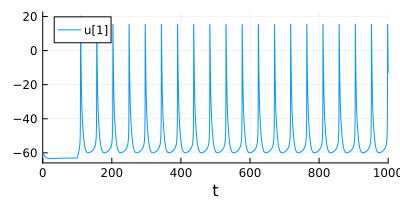

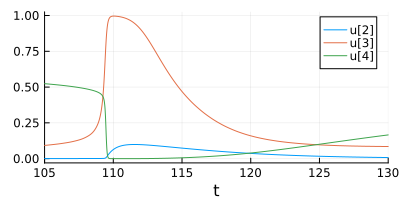

In [79]:
display(plot(sol, idxs = 1, size=(400, 200)))
display(plot(sol, idxs = [2, 3, 4], tspan = (105.0, 130.0), size=(400, 200)))